# Similar slides

The training data contains near duplicate slides which come from serial sections. The same tissue sample is sliced multiple times but these are essentially different parts and not duplicate although they may look similar.

### What to do with serial sections?

Replicate slides of the same tissue sample are physically different and shouldn't be removed. However, they can be very similar to each other and they have same labels so this is problematic for evaluation. Replicates shouldn't be placed in same cross-validation folds to avoid sample memorization.

[Detecting duplicates](https://www.kaggle.com/appian/panda-imagehash-to-detect-duplicate-images/data?)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import MultiImage
from PIL import Image
import cv2
import os
import imagehash
import torch
from tqdm.notebook import tqdm

In [2]:
import random
from sklearn.model_selection import StratifiedKFold

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def prepare_data(TRAIN, LABELS, nfolds, seed):
    df = pd.read_csv(LABELS).set_index('image_id')
    files = set([p[:32] for p in os.listdir(TRAIN)])
    df = df.loc[files]
    df = df.reset_index()
    splits = StratifiedKFold(n_splits=nfolds, random_state=seed, shuffle=True)
    splits = list(splits.split(df,df.isup_grade))
    folds_splits = np.zeros(len(df)).astype(np.int)
    for i in range(nfolds): folds_splits[splits[i][1]] = i
    df['split'] = folds_splits
    return df

In [5]:
TRAIN = '../../train_1_256_128_4x4-skeleton-mask/'
seed_everything(2020)
df = prepare_data(TRAIN, '../../prostate-cancer-grade-assessment/train.csv', 4, 2020)
df.tail(2)

,image_id,data_provider,isup_grade,gleason_score,split
10506,3b82f3a80bd8bef6a0353a4443185c4e,radboud,5,4+5,0
10507,2d1ab39f0ff6e7285467da5c26750d20,radboud,4,4+4,1


## Open full slide images
We are only interested in the overall shape which should be similar in within serial sections. This means we can safely resize a lot smaller.

In [8]:
def openResized(img_id,size=(128,128)):
    fn = os.path.join('../../prostate-cancer-grade-assessment/train_images', img_id + '.tiff')
    mimg = MultiImage(fn)
    ds_img = cv2.resize(mimg[2], size ,cv2.INTER_NEAREST)
    del mimg
    return ds_img

CPU times: user 86.1 ms, sys: 20.1 ms, total: 106 ms
Wall time: 362 ms


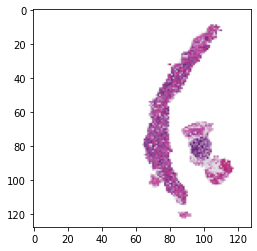

In [9]:
%%time
plt.imshow(openResized(df.image_id.values[100]))

## ImageHash

In [10]:
funcs = [
    imagehash.average_hash,
    imagehash.phash,
    imagehash.dhash,
    imagehash.whash,
]

def getImageHash(img):
    pil_im =  Image.fromarray(img)
    img_hash = np.array([f(pil_im).hash for f in funcs]).reshape(256)
    del pil_im
    return img_hash

In [11]:
%%time
getImageHash(openResized(df.image_id.values[100]))

CPU times: user 47.1 ms, sys: 7.16 ms, total: 54.2 ms
Wall time: 124 ms


array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
       False, False, False,  True,  True,  True,  True,  True, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True, False, False,
        True, False, False,  True,  True, False, False,  True,  True,
       False, False,  True,  True, False, False,  True, False,  True,
        True, False, False, False,  True, False,  True, False,  True,
        True, False,  True,  True, False,  True, False,  True,  True,
       False,  True, False, False, False, False,  True, False, False,
        True, False, False,  True, False,  True, False,  True,  True,
       False,  True,

In [12]:
hashes = []
for img_id in tqdm(df.image_id.values, total=len(df.image_id.values)):
    try:
        hashes.append(getImageHash(openResized(img_id)))
    except:
        print(f'{img_id} failed. Appending all False vector')
        hashes.append(np.zeros(256,np.bool))

In [13]:
hashes = torch.Tensor(np.array(hashes).astype(int)).cuda()

Calculate similarity scores

In [14]:
sims = np.array([(hashes[i] == hashes).sum(dim=1).cpu().numpy()/256 for i in range(hashes.shape[0])])

In [15]:
sims.shape

(10508, 10508)

Text(0, 0.5, 'number of replicates')

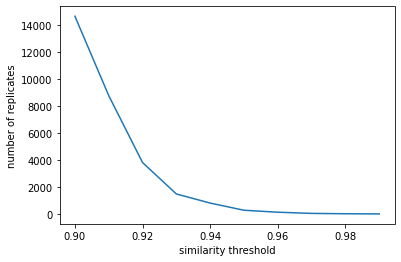

In [16]:
# try a few different thresholds to see how many replicates we get
xs = np.linspace(0.9,0.99,10)
ys = np.zeros_like(xs)
for ind, x in enumerate(xs):
    y = 0
    dups = np.where(sims > x)
    for i,j in zip(*dups):
        if i == j:
            continue
        y+=1
    ys[ind] = y
plt.plot(xs,ys)
plt.xlabel('similarity threshold')
plt.ylabel('number of replicates')

Threshold 0.945 looks like a good threshold with high recall and not too many false positives.

28de07f534e1942fb63732ccd9e09338 cb3e71bd3331bf85370d0a3a3071f47c


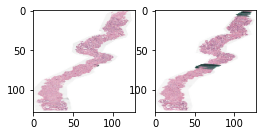

cca735c397880e88192e97d68b97754e 4abf4f8b4b7768af6eb06d3ef31b1e09


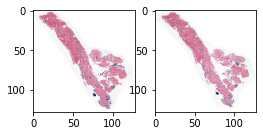

2592cfd1d3e053e519598bab9423d279 18533bc08197fa92ff063ad89ceddc89


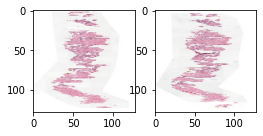

e6e365522c68d41ad595fc1b737223ec 743ba77cb6d84359b3d3b4e8553b57ae


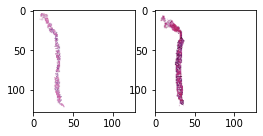

dd549fc1dbc7db15b94d1a0cfd7de309 955f09b99664b07b0cf18768c84f2253


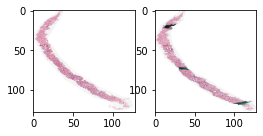

35c399eb25d0d2fbf45481de19e53366 564252dc7eb1c27099ab70a95e189748


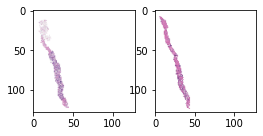

59c75ad5b178f5f2860deef480d6837b 7f68f25905c0dea4a017fb78e1c61b21


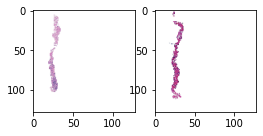

a48b27a0f0f78595b8d71a4b373acf81 7fa4634ab59a7832bc877fef162eacaa


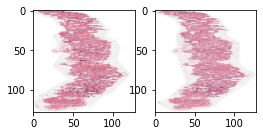

e6a6f4658717ef0c20e18cc89b96f4e6 bda25c48ac8086cccbf2397e13166046


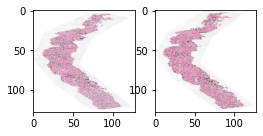

760f8945b00dc239d46a48bc34909eb6 7c440d8eb7dbda63b0b45b7773fa8279


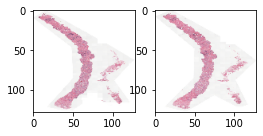

1f8c98a43c6e755c2b3a785db72520e1 06fe0864a99a2e0cd32cb141b7808912


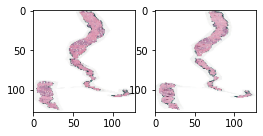

bfdbe56fb7fc4d7b3d151370f897d503 cdefc4649194000c27f3fa17f936d517


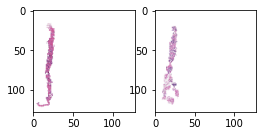

7a0a36bc6119e3d78474e6c8ca875725 ea954ce0f1563b69d79bd1c2b7129618


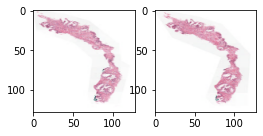

73df680f7884e13355a1f1fc2bacc3a4 b353c4f536a4a45c93cd2908138662e4


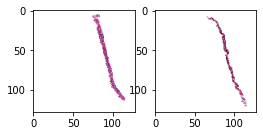

5c083ab21fc57c0954468ab46aa7fb16 9793c3c2317f38143d21a5187bb35652


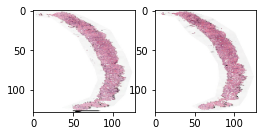

f9caed448e138e702ee5a2c906a671fc cd636fee80a3058dcd3f5428d997a153


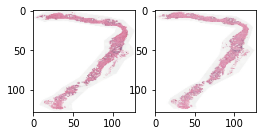

da09fe1419dcf0c2e16c0b2a43979c43 52ac47312c73298f955efdf80e1059b5


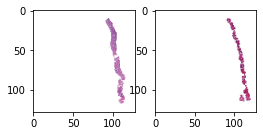

e9c5d5ae46eb2a57b0c577a156cda8b7 6af8999282337b9d7255ad5b12fe3909


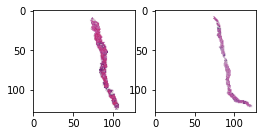

8520e95c49091fe5676146fcedfb3793 fc6a695ba44f4b64425c522f590bac48


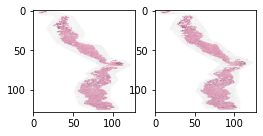

af4e9bbfb08853b7b2813331fbe5b877 58c59865a2b61e6dcd15fdd75c03f8ce


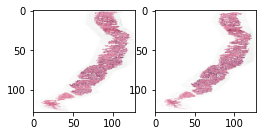

28cf4db2f0e24ad607e0267e83980799 9c0f575d90a8281e6600f490ea79b9ee


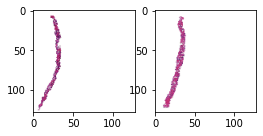

28cf4db2f0e24ad607e0267e83980799 6bdfc45ee2e638d83c9dbc6e618a7aae


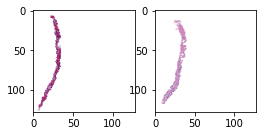

62e36f7cc417a5e10b21466267b327ca 7ee441bf99f40865e465910785ea56ce


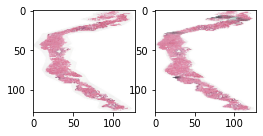

337917b03be19ec176ed5b3e77f6e55b 8ef59d7cb53bf92b5c589f7377edb0d7


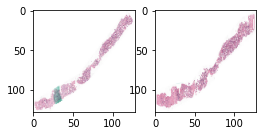

291b2132e1fb9131478b8d691406874b a579110fe1e670847d9d146404597750


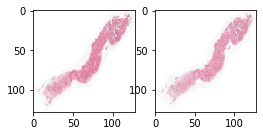

72aa3eb389001c2e3ceeb58e7b48dfe9 78e15fff6ef70715b6f5b44caf905f97


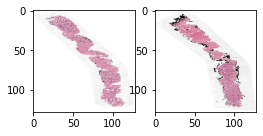

7b3f3b2a473fa265132ca41c139372b0 ee182a14e532b122f40d561d87eb2136


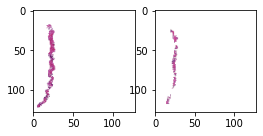

90425f972de4b100dcb1a773f29a7907 0eb6bb946906a834fb91bfd5fc0f720d


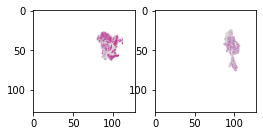

e0c4272da1f0609fa73fd440d4c6865d bf6671ee64037cd05665b5e51a9063e0


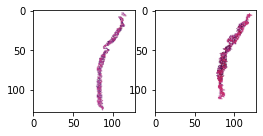

b640ae62431d5a81eff0992bc612c9e6 ae4eece1cdf581598449b32f7747f3a6


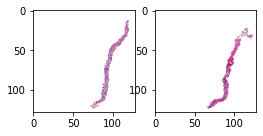

f480b897adfe65f572f79d9f8d45ac9e 1cdd6def1e3099a9763938457cf0b4be


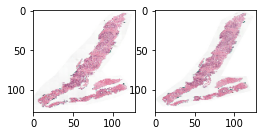

2ee68cce1ed0a65cf352ed55488979a0 c4bcc0bc2da6444a5e4300f7bd2f577c


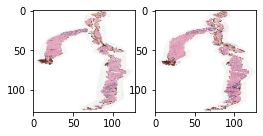

7fa4634ab59a7832bc877fef162eacaa a48b27a0f0f78595b8d71a4b373acf81


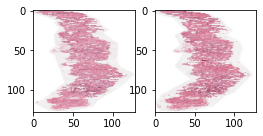

f5675cb89a120e225ca8929b64a5af79 3602a55ad5d1bc6c6cd903538b5b5abe


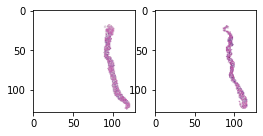

f5675cb89a120e225ca8929b64a5af79 a295d73e91c9f8d8d16a8c1a3469714a


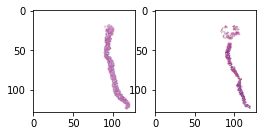

f5675cb89a120e225ca8929b64a5af79 f5e7ea2d4a298e622a4fd05b8d2cc4fb


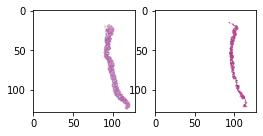

00c52cb4db1c7a5811a8f070a910c038 b7932b71e15722e1908ad98af13d50fb


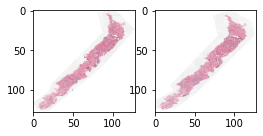

df4146c2cb4e97d9c227bdd90d4dc6f8 63226114e772943ce7f8017d9f5d4b90


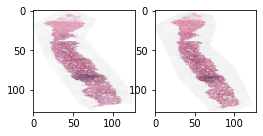

bc93d165d96e4fa4883f130b3f7b9885 f5d40a40e34f8a090f44cb6589c26900


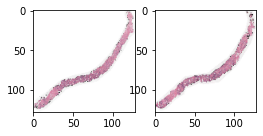

b3c9178d328c9a8362be6b7a55614287 61d53ad3869b865564520488312443f2


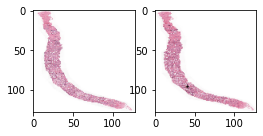

2baf0e44d4c112ec9d268029638ea7f8 fe309f77902a9790166ad50bbeda0eb5


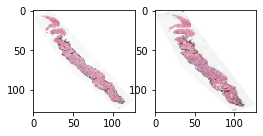

10a8a9a745a971ab7ed129c6283a3f7d 964e3c2fc696bb6d6147b24dacabd54d


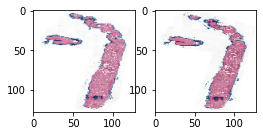

4529b55616610e6206384be8245d1238 e5c045c4083859b242af4d1b3bc1dc65


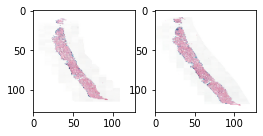

dbcfc69f6726c51aaa6381efe5bbf8c6 a9401a16f89aabfa1821aba90a64d3d6


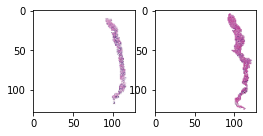

c8cb1c570b772e3f7943e254ba096e9e 56deba64468141b0968ad8899b121b15


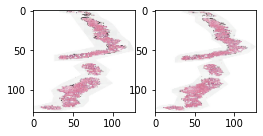

1f86b6a526481bc5d2ca18d94f94f062 6e4491b337dde383cdf2a75685dee968


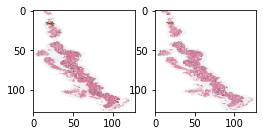

9fa46cfece4259875670f7e788b3326d 448886cc21e672bbf711badd2d5b01da


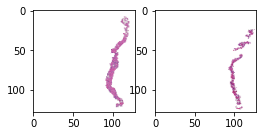

e62a7175ca466fb365631d124972c0a8 92d9151ac1696151907d63db1116efa1


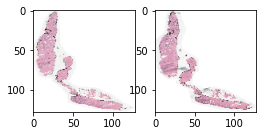

cb4dce32e66ce659b386933a77ff59b1 b5ad6c0446b987d1f33df121e2512331


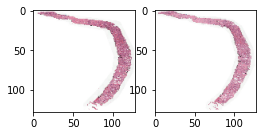

49db2dc6d2b8ec83e08ecb69182012e1 f1f74c4aecfa7f9baa760bb992e4c720


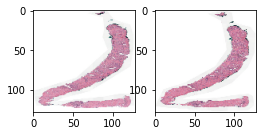

afa70cee560c0b557c12a0cf0ca7611f 6f7964ccd7bf337793b91b0a2c4266ca


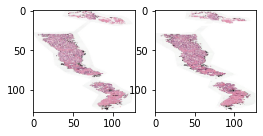

409a4a93c34c808803f6f2059e1161bd fad1b577d2eb44cd0d686af308422638


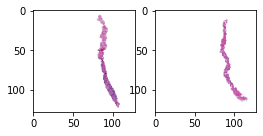

c29a172145a30a79b05c6f0216a1dbef 88591e92de81634c6b9870259b25d59c


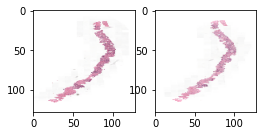

22756712280d5fcf0c9ca638fdcaa661 060fb11087bfa2be0b810fad986328c2


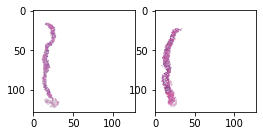

22756712280d5fcf0c9ca638fdcaa661 5670a325584c3bd7c9f2bdfc128e2e67


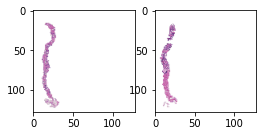

6ccced7f24b2fa0a84639d192f3a9679 c3e5fb7918f8ae0763e32551e8abfda6


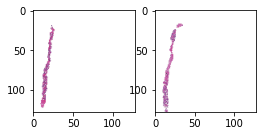

0b4fba162fc179a4cf63cc986f72ac4c f4ee61458d542b826014e72cb224a0b6


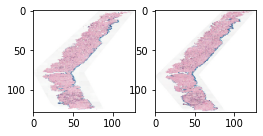

3acfefa2f174d9f3f555cae12f5394ee 1329fffac9982cca468efe133cfacf50


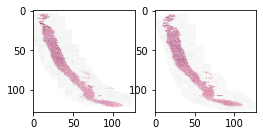

448886cc21e672bbf711badd2d5b01da 9fa46cfece4259875670f7e788b3326d


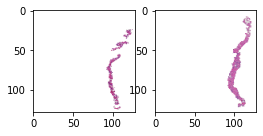

448886cc21e672bbf711badd2d5b01da e5fe44e45e6954360aeccfeac99c2885


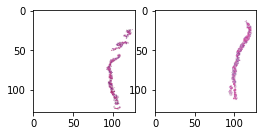

d49075075de98ba225b3306bc8cfca44 25a27922edaf3f338e8693ededcbe1c2


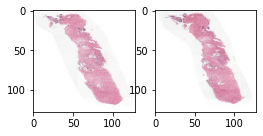

92d9151ac1696151907d63db1116efa1 e62a7175ca466fb365631d124972c0a8


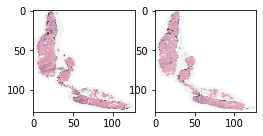

20ec7cf1e184baab03dad85a1a601532 c7579439b6073eed35a3df5a541b3949


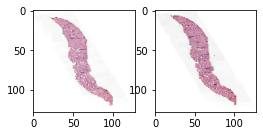

8982520da76f908b20b9f66c07ccc1e5 9dbc64b9e7a18cfdd825ea44219b8330


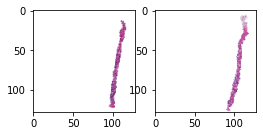

8ca6ea383b58c9ed7f3b7bdc35b29761 a04d7b32a88c1d2f397b67ff083f5313


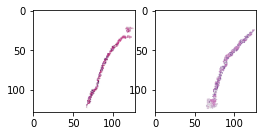

9e5cd1fc52ee72cb0658f1e403aa00ad f68673db7c65bc80fde188dea0e39c0b


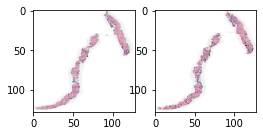

8ae069858aecbad846f4d69d405f9bd6 a5dbc558ca9c9612b608645238c15129


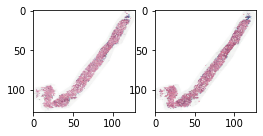

79a741c8d6157f85a761d3de05986311 f157ea3c41b34368266d9f802814292a


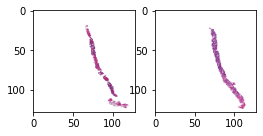

35cc820298fb447703ab51875b3966d2 81da1181330200bf01e70ecc233ba989


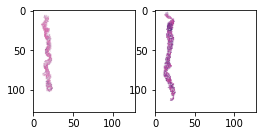

35cc820298fb447703ab51875b3966d2 e3360926180928287a4d96973e10926a


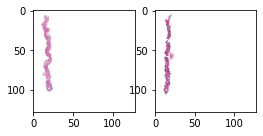

5a5b227860e8d559b45519851908fb03 69e2eab0eae3bb4ca3650e3854534f32


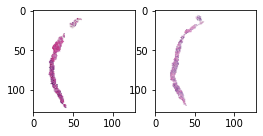

9380b3a7b261bce9b376b110aaee787c 447ecc048098b19ca337690c94c59f0c


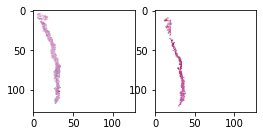

9380b3a7b261bce9b376b110aaee787c 2c64c620bb90c077032831ccc57361dd


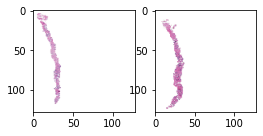

ae57810f8bfc53392b2001d9cc684cde 3a07181ebf2769bfd8c47dc46046d64d


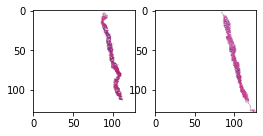

dc2ec851fcbf594f11b023387ac15003 303090fcc31ecc2584e6addeadfa1402


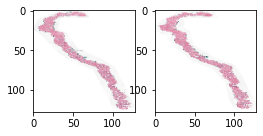

23ec43578519dac256b3f6ce800b82e7 cf9f541c28be35984163546c15ddfe09


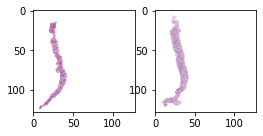

db6d351561cec54486ab371f4faf3b40 9b42c63d8a82e49ae1c724f5d58fe304


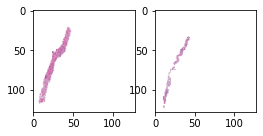

56e5d931e0c46a942e76aaa95485b9cd 878e0b1bbfa299387e3afed9d7c372bf


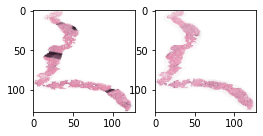

7a1b601b146af835cef2bc71ea599c65 441265c6b4598e9bcd10bc10eb6293cc


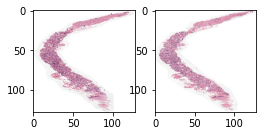

ea954ce0f1563b69d79bd1c2b7129618 7a0a36bc6119e3d78474e6c8ca875725


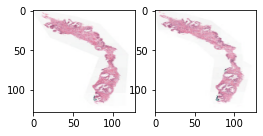

836ca5d73c88ad94fb980ca3e5e65da7 b06b4755a9bbdb1e304f98a5d71e3c29


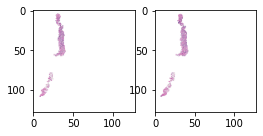

c4bcc0bc2da6444a5e4300f7bd2f577c 2ee68cce1ed0a65cf352ed55488979a0


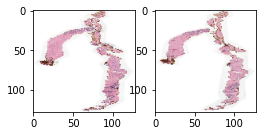

7d60fa34382d46eddec04ec8acb4cb52 5b2c1fcb4a370400b64df671560fb733


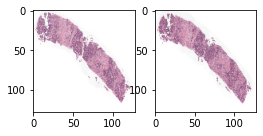

c2a487c3082523f815ca8541a01f293d 7d86f5cdc00bc73a75b43d06ef14c106


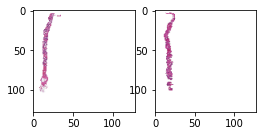

9746a908fb142b961e5b0b1afef3dac4 c9dbdd9c9fc0eab0d235499488b26c53


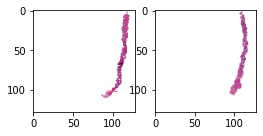

17e370eedaa11c265e5cabb3601a2fd2 eaa98a57d64de34ccb77c1af98e1d39a


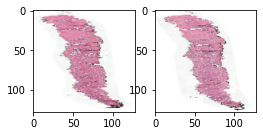

aef2f50710677c1204538d88d3475e63 5dfb4fde4486edf9f5863e61a1ba016c


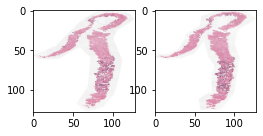

dfb94f6d16ff40e04681be2c2fde7fcd 149fd3c5d3ede543589633ea0e711c24


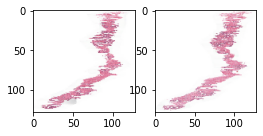

88bde4c99e9dff4e732dd21be1bb939b ba4a1e8412d6376304ae051d32184ce6


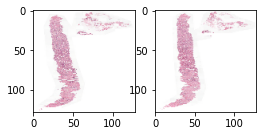

eaa98a57d64de34ccb77c1af98e1d39a 17e370eedaa11c265e5cabb3601a2fd2


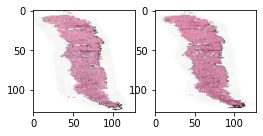

1fd3d60b4833d266003fce5f17205baa 9b420fa839c2a9e3f03836e9b1b6de4b


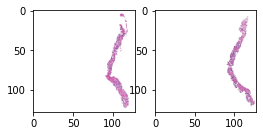

82b8e31cf5bd59934af005c609d05e64 c35e39e522cb0a93ecd114c71e72af05


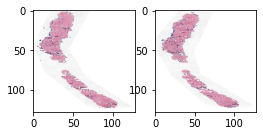

e175edbb01ee93372ae54bdc1734bcf5 306c500894cef0f73406f227152ef357


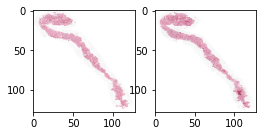

528423d80e99a91576623f1772942237 9b92d948f0a8ca765ef5ca7ae650273d


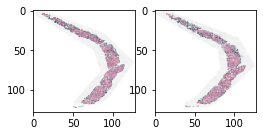

450f03b3f86c156365c1f7ef8e38f995 b6cffe7fcd24b70b911495e4120e6d84


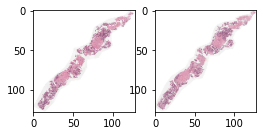

367f122e80bcd0bffc02f6a04c1d8234 9effeea56c413b92340b89d1240769c1


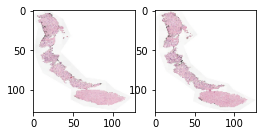

367f122e80bcd0bffc02f6a04c1d8234 b5343f9567df8a68c3276f8d8cdcc6a5


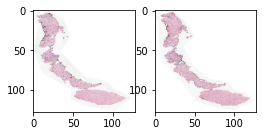

4f533826b961b84eb76169c1a94c61ee d19abb9c2a1826a5aae68c21f97def14


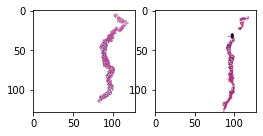

424695a2886897279fd2d40c394d7848 96907a7abf71ca7e5e48b36514d6c7f2


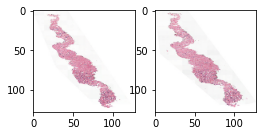

435f5526bfee811bcd4bbf54ad40b600 d0722f1c8a76133ce8400a4c1dafce5a


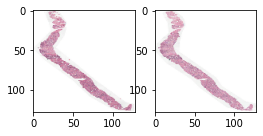

In [17]:
# Let's check image pairs with similarity larget than threshold.
# You can lower threshold to find more duplicates (and more false positives).

import matplotlib.pyplot as plt

threshold = 0.945
duplicates = np.where(sims > threshold)

pairs = []
for (i,j) in zip(*duplicates):
    if i == j:
        continue
    pairs.append([i,j])
    #print only the first hundred
    if len(pairs) > 100:
        continue
    img_id1 = df.image_id.values[i]
    img_id2 = df.image_id.values[j]
    
    print(img_id1, img_id2)

    image1 = openResized(img_id1)
    image2 = openResized(img_id2)

    fig,ax = plt.subplots(figsize=(4,2), ncols=2)
    ax[0].imshow(image1)
    ax[1].imshow(image2)
    plt.show()

In [18]:
len(pairs)

544

Similar images might have multiple copies. This script will search all related indices.

In [19]:
def findAllReplicates(pairs, seed):
    replicates = [seed]
    nodes = [seed]
    
    def addReplicate(n):
        if n not in replicates:
            replicates.append(n)
            nodes.append(n)
    
    # while there are nodes left
    while len(nodes) > 0:
        this_node = nodes[0]
        for i,j in pairs:
            if i==this_node:
                # match - add j to replicates
                addReplicate(j)
            elif j==this_node:
                # match - add i to replicates
                addReplicate(i)
        nodes.pop(0)
    return replicates

In [20]:
findAllReplicates(pairs, 7194)

[7194]

Data loading uses these in constructing folds. 

In [21]:
seed = 2020
nfolds=4
seed_everything(seed)
df = prepare_data(TRAIN, '../../prostate-cancer-grade-assessment/train.csv', nfolds, seed)
df.tail()

,image_id,data_provider,isup_grade,gleason_score,split
10503,ef55278e83dc8ce2b214880eb444d59d,radboud,1,3+3,0
10504,fa5a65d858a5cc0466e8c5a06b735499,karolinska,1,3+3,3
10505,14d4d7374400dc55ce7cc8d184c9a4c7,karolinska,2,3+4,1
10506,3b82f3a80bd8bef6a0353a4443185c4e,radboud,5,4+5,0
10507,2d1ab39f0ff6e7285467da5c26750d20,radboud,4,4+4,1


#### Isup grades before modifying folds

fold 0


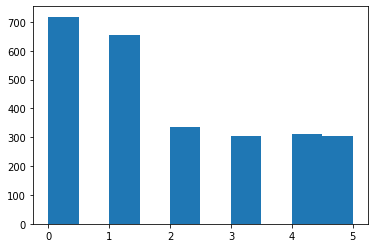

fold 1


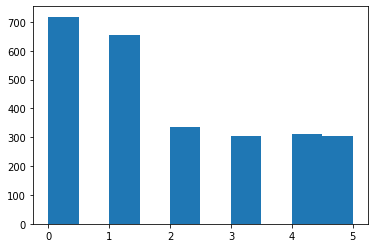

fold 2


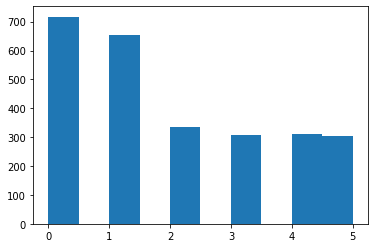

fold 3


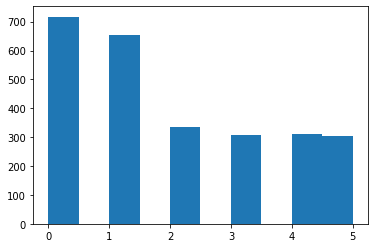

In [22]:
for fold in range(nfolds):
    print(f'fold {fold}')
    plt.hist(df[df.split==fold].isup_grade.values)
    plt.show()

In [23]:
np.unique(np.array(pairs)).shape

(495,)

In [24]:
def pairs2sameFolds(df,pairs):
    replicate_indices = np.unique(np.array(pairs))
    split_values = df.split.values
    for ind in replicate_indices:
        allReps = findAllReplicates(pairs, ind)
        # set all to the same fold as the minimum index
        min_rep = min(allReps)
        target_fold = split_values[min_rep]
        for rep in allReps:
            split_values[rep] = target_fold
    df.split = split_values
    return df

In [25]:
df = pairs2sameFolds(df, pairs)

#### Isup grades after fold swaps

fold 0


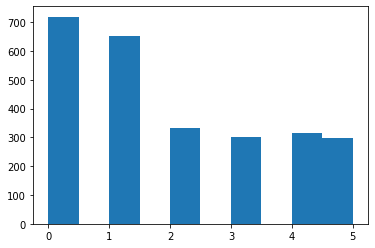

fold 1


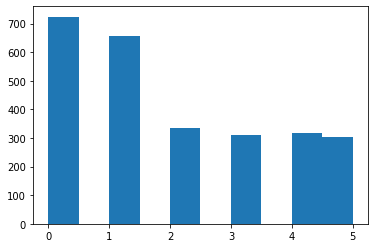

fold 2


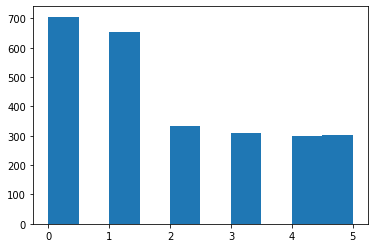

fold 3


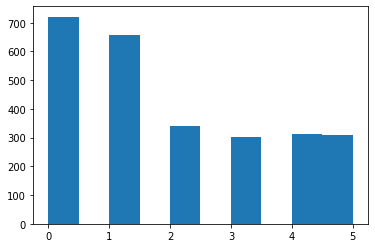

In [26]:
for fold in range(nfolds):
    print(f'fold {fold}')
    plt.hist(df[df.split==fold].isup_grade.values)
    plt.show()

Save pairs to a file

In [27]:
np.save('../pair_indices.npy',np.array(pairs))

In [28]:
np.array(pairs).shape

(544, 2)

In [29]:
df.tail()

,image_id,data_provider,isup_grade,gleason_score,split
10503,ef55278e83dc8ce2b214880eb444d59d,radboud,1,3+3,0
10504,fa5a65d858a5cc0466e8c5a06b735499,karolinska,1,3+3,3
10505,14d4d7374400dc55ce7cc8d184c9a4c7,karolinska,2,3+4,1
10506,3b82f3a80bd8bef6a0353a4443185c4e,radboud,5,4+5,2
10507,2d1ab39f0ff6e7285467da5c26750d20,radboud,4,4+4,1
